In [1]:
#Import libraries
import os
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

#tensorflow 2.4.0
import tensorflow as tf
from tensorflow.keras import layers, models

#https://www.tensorflow.org/tutorials/images/classification?hl=ko

In [2]:
#Initailize setting
data_dir = pathlib.Path('../gender-class-tf-data')
save_path = os.getcwd()
class_names = np.array([item.name for item in data_dir.glob('*')])
print(class_names)

['man' 'woman']


In [3]:
#Load dataset
batch_size = 32
img_height = 50
img_width = 50

train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir,
                                                               color_mode="grayscale",
                                                               validation_split=0.2,
                                                               subset="training",
                                                               seed=123,
                                                               image_size=(img_height, img_width),
                                                               batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir,
                                                             color_mode="grayscale",
                                                             validation_split=0.2,
                                                             subset="validation",
                                                             seed=123,
                                                             image_size=(img_height, img_width),
                                                             batch_size=batch_size)

Found 2372 files belonging to 2 classes.
Using 1898 files for training.
Found 2372 files belonging to 2 classes.
Using 474 files for validation.


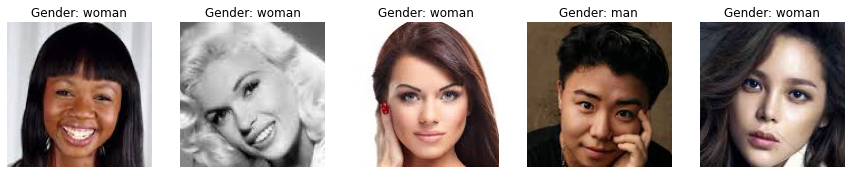

In [4]:
#print few random pictures
n = 5
fig, axes = plt.subplots(1, n, figsize=(15,15))

for i in range(n):
    random_gender = random.choice(class_names)
    random_image = random.choice(list(data_dir.glob(random_gender+'/*.jpg')))
    image = plt.imread(random_image)
    axes[i].imshow(image)
    axes[i].set_title("Gender: "+random_gender)
    axes[i].axis('off')

In [5]:
#Improve dataset performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [6]:
#Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width, 1)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
])

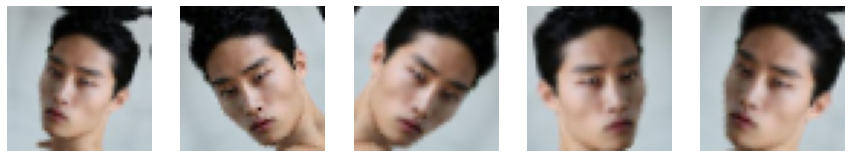

In [7]:
#print random picture's augmented version
plt.figure(figsize=(15, 15))

random_gender = random.choice(class_names)
random_image = random.choice(list(data_dir.glob(random_gender+'/*.jpg')))
img = tf.keras.preprocessing.image.load_img(random_image, target_size=(img_height, img_width))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
for i in range(5):
    augmented_images = data_augmentation(img_array)
    ax = plt.subplot(1, 5, i+1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [8]:
#Make model
num_classes = 2

model = tf.keras.models.Sequential([
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(32, 9, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 5, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes)
])

In [9]:
#Model compile and summary
model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 50, 50, 1)         0         
_________________________________________________________________
rescaling (Rescaling)        (None, 50, 50, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 50, 50, 32)        2624      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 25, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 128)      

In [10]:
#Training
epochs = 60
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/60
60/60 [==============================] - 14s 203ms/step - loss: 0.6686 - accuracy: 0.5823 - val_loss: 0.6639 - val_accuracy: 0.5570
Epoch 2/60
60/60 [==============================] - 11s 181ms/step - loss: 0.6342 - accuracy: 0.6395 - val_loss: 0.5389 - val_accuracy: 0.7300
Epoch 3/60
60/60 [==============================] - 11s 180ms/step - loss: 0.5685 - accuracy: 0.7072 - val_loss: 0.4683 - val_accuracy: 0.7806
Epoch 4/60
60/60 [==============================] - 11s 182ms/step - loss: 0.5422 - accuracy: 0.7243 - val_loss: 0.4696 - val_accuracy: 0.7679
Epoch 5/60
60/60 [==============================] - 11s 180ms/step - loss: 0.5253 - accuracy: 0.7326 - val_loss: 0.4491 - val_accuracy: 0.7954
Epoch 6/60
60/60 [==============================] - 11s 180ms/step - loss: 0.5309 - accuracy: 0.7320 - val_loss: 0.4404 - val_accuracy: 0.7996
Epoch 7/60
60/60 [==============================] - 11s 182ms/step - loss: 0.4883 - accuracy: 0.7846 - val_loss: 0.4865 - val_accuracy: 0.8122

In [11]:
#Save model
tf.saved_model.save(model, save_path)

INFO:tensorflow:Assets written to: C:\Users\yang\Documents\GitHub\gender-class-tf\assets


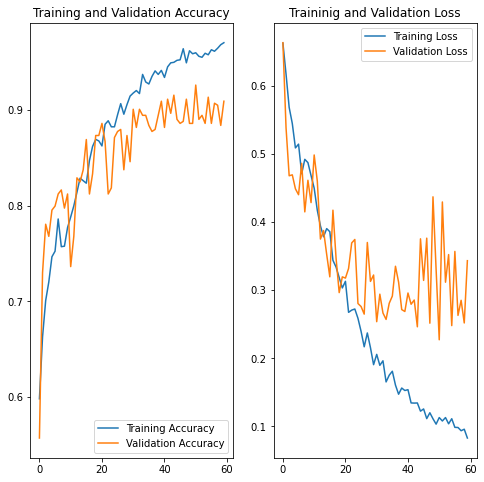

In [12]:
#Accuracy and loss graph
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Traininig and Validation Loss')
plt.show()

In [13]:
#